In [1]:
import sys
!{sys.executable} -m pip install keras

     |████████████████████████████████| 640 kB 12.6 MB/s eta 0:00:01
     |████████████████████████████████| 25.9 MB 17.8 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
# Verify GPU is detected
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2647013400781154472
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6936900416
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5016016944458669517
physical_device_desc: "device: 0, name: GeForce RTX 3070, pci bus id: 0000:2d:00.0, compute capability: 8.6"
]
2.4.1
Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from keras.datasets import imdb
import numpy as np
from keras import preprocessing

max_words = 10_000
max_length = 20

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words)

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=max_length)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=max_length)


17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [32]:
# Create description and label arrays from JSON file
import json
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical

# JSON file from https://www.kaggle.com/zynicide/wine-reviews?select=winemag-data-130k-v2.json
with open('/tf/wine-data.json') as json_file:
    data = json.load(json_file)
    
descriptions = []
labels_string = []
    
for review in data:
    descriptions.append(review['description'])
    labels_string.append(review['variety'])
    
labels_set = set(labels_string)
    
label_mapping = { x: i for i, x in enumerate(labels_set) }
labels = [label_mapping[label_string] for label_string in labels_string]
print(labels_string[:20])
print(labels[:20])
    
max_words = 10_000
max_length = 20

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(descriptions)

sequences = tokenizer.texts_to_sequences(descriptions)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))
    
num_labels = len(set(labels))
print('Found %s unique labels' % len(label_mapping))

padded_data = pad_sequences(sequences, maxlen=max_length)
labels = np.asarray(labels)

print('Shape of data tensor: ', padded_data.shape)
print('Shape of label tensor: ', labels.shape)

indices = np.arange(padded_data.shape[0])
np.random.shuffle(indices)

data = padded_data[indices]
labels = labels[indices]
one_hot_labels = to_categorical(labels)

x_train = data
y_train = one_hot_labels

['White Blend', 'Portuguese Red', 'Pinot Gris', 'Riesling', 'Pinot Noir', 'Tempranillo-Merlot', 'Frappato', 'Gewürztraminer', 'Gewürztraminer', 'Pinot Gris', 'Cabernet Sauvignon', 'Gewürztraminer', 'Cabernet Sauvignon', 'Nerello Mascalese', 'Chardonnay', 'Riesling', 'Malbec', 'Malbec', 'Tempranillo Blend', 'Meritage']
[317, 700, 125, 240, 648, 513, 404, 586, 586, 125, 474, 586, 474, 9, 679, 240, 415, 415, 494, 397]
Found 37550 unique tokens
Found 708 unique labels
Shape of data tensor:  (129971, 20)
Shape of label tensor:  (129971,)


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 20, 64)            640000    
_________________________________________________________________
flatten_11 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 708)               906948    
Total params: 1,546,948
Trainable params: 1,546,948
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
813/813 [==============================] - 3s 3ms/step - loss: 4.1439 - acc: 0.1439 - val_loss: 3.0736 - val_acc: 0.2916
Epoch 2/10
813/813 [==============================] - 2s 3ms/step - loss: 2.9200 - acc: 0.3167 - val_loss: 2.8361 - val_acc: 0.3380
Epoch 3/10
813/813 [==============================] - 2s 3ms/step - loss: 2.6344 - acc: 0.3728 - val_loss: 2.

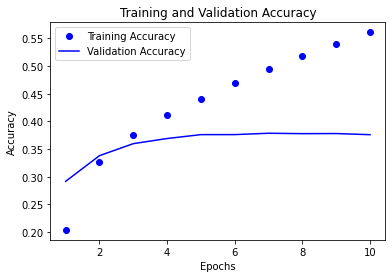

In [48]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, LSTM

model = Sequential()

model.add(Embedding(max_words, 64, input_length=max_length))
model.add(Flatten())
model.add(Dense(num_labels, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(
    x_train, 
    y_train, 
    epochs=10, 
    batch_size=128,
    validation_split=0.2)

import matplotlib.pyplot as plt

history_dict = history.history
acc_values = history_dict['acc']
validation_acc_values = history_dict['val_acc']

epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, acc_values, 'bo', label='Training Accuracy')
plt.plot(epochs, validation_acc_values, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

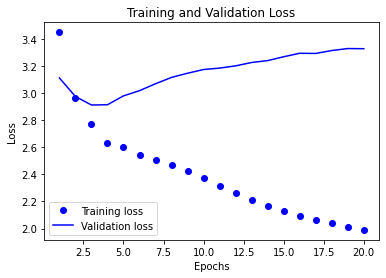

In [43]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
validation_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, validation_loss_values, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

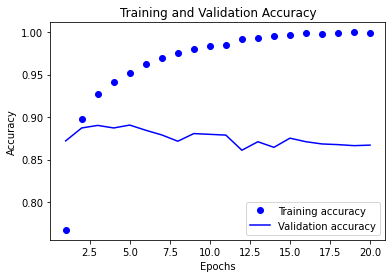

In [8]:
import matplotlib.pyplot as plt

history_dict = history.history
accuracy_values = history_dict['accuracy']
validation_accuracy_values = history_dict['val_accuracy']

epochs = range(1, len(accuracy_values) + 1)

plt.plot(epochs, accuracy_values, 'bo', label='Training accuracy')
plt.plot(epochs, validation_accuracy_values, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [27]:
from keras import models, layers

model = models.Sequential()

model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    x_train, 
    y_train, 
    epochs=4, 
    batch_size=512)

results = model.evaluate(x_test, y_test)
print(model.predict(x_test))

Epoch 1/4
49/49 [==============================] - 1s 6ms/step - loss: 0.5454 - accuracy: 0.7356
Epoch 2/4
49/49 [==============================] - 0s 6ms/step - loss: 0.2703 - accuracy: 0.9064
Epoch 3/4
49/49 [==============================] - 0s 6ms/step - loss: 0.2023 - accuracy: 0.9294
Epoch 4/4
782/782 [==============================] - 1s 623us/step - loss: 0.3132 - accuracy: 0.8766
[[0.2589469 ]
 [0.9999492 ]
 [0.98974466]
 ...
 [0.1621336 ]
 [0.14407909]
 [0.81090415]]


In [13]:
# Decode a given review
def decode_review(index):
    word_index = imdb.get_word_index()
    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

    return ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[index]])

decode_review(2)

"? this has to be one of the worst films of the 1990s when my friends i were watching this film being the target audience it was aimed at we just sat watched the first half an hour with our jaws touching the floor at how bad it really was the rest of the time everyone else in the theatre just started talking to each other leaving or generally crying into their popcorn that they actually paid money they had ? working to watch this feeble excuse for a film it must have looked like a great idea on paper but on film it looks like no one in the film has a clue what is going on crap acting crap costumes i can't get across how ? this is to watch save yourself an hour a bit of your life"